In [1]:
%load_ext rpy2.ipython

In [3]:
%%R
library(phyloseq)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)

####Read in sample metadata

In [4]:
%%R
sample.md = read.table("data/Metadata_fungi.txt", 
                comment.char = "",
                header = TRUE,
                colClasses = c("Density" = "numeric"))
rownames(sample.md) = as.character(sample.md[, 1])

sample.md = sample_data(sample.md)

#### Read in OTU table

In [5]:
%%R
physeq = import_biom("data/otu_table_wtax.biom") 

#### Add sample metadata to phyloseq object

In [6]:
%%R
sample_data(physeq) = sample.md
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2032 taxa and 173 samples ]
sample_data() Sample Data:       [ 173 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 2032 taxa by 7 taxonomic ranks ]


In [7]:
%%R
g = psmelt(physeq)
head(g)

          OTU    Sample Abundance  SampleID Primers       i2       i1 Day
50      OTU.1   D1413.9     33528   D1413.9      30 cgtgagtg actcactg  14
150     OTU.1  D1413.10     33074  D1413.10      31 ggatatct actcactg  14
216840 OTU.34 Mock.Comm     31506 Mock.Comm     175 ggatatct tgctcgta  NA
108436  OTU.2  D3013.10     30125  D3013.10      91 tagcgagt tatagcga  30
76      OTU.1  D1413.11     25235  D1413.11      32 gacaccgt actcactg  14
173     OTU.1   D1413.6     23819   D1413.6      27 tagcgagt actcactg  14
        Density Treatment Mock_Comm RNA_DNA    Rank1         Rank2
50     1.735145    13CCPS         N     DNA k__Fungi          <NA>
150    1.729681    13CCPS         N     DNA k__Fungi          <NA>
216840       NA      <NA>         Y     DNA k__Fungi p__Ascomycota
108436 1.731866    13CCPS         N     DNA k__Fungi p__Ascomycota
76     1.725310    13CCPS         N     DNA k__Fungi          <NA>
173    1.751536    13CCPS         N     DNA k__Fungi          <NA>
             

In [8]:
%%R
f = filter(g, Primers %in% c(57,58,59,60,61,62,63,64))

In [82]:
%%R
comp_all = g %>%
group_by(Rank3) %>%
summarise(counts = n()) 

tail(comp_all, n = 20)

Source: local data frame [20 x 2]

                    Rank3 counts
                   (fctr)  (int)
1     c__Chytridiomycetes    519
2  c__Cystobasidiomycetes    346
3         c__Dacrymycetes    173
4      c__Dothideomycetes  15224
5       c__Eurotiomycetes  24912
6    c__Exobasidiomycetes    519
7       c__Glomeromycetes   2941
8       c__Incertae_sedis  10034
9      c__Lecanoromycetes    173
10       c__Leotiomycetes   3806
11  c__Microbotryomycetes   2941
12      c__Orbiliomycetes   3114
13       c__Pezizomycetes   1557
14     c__Pucciniomycetes    173
15     c__Saccharomycetes   8131
16     c__Sordariomycetes  58647
17     c__Tremellomycetes   6055
18        c__unidentified 139265
19   c__Ustilaginomycetes    173
20                     NA  38406


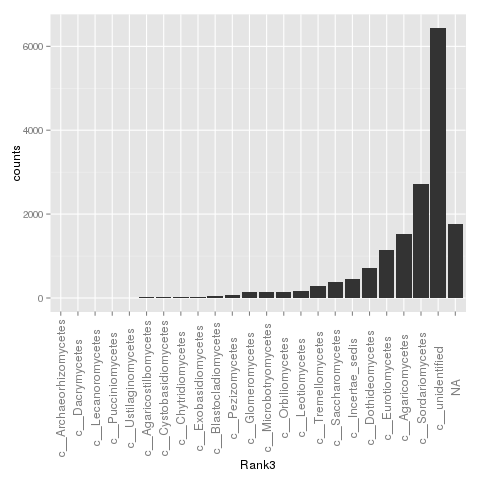

In [11]:
%%R
comp_filt$Rank3 <- factor(comp_filt$Rank3, levels = comp_filt$Rank3[order(comp_filt$counts)])
p = ggplot(comp_filt, aes(x = Rank3, y = counts)) + geom_bar(stat = "identity")
p = p + theme(axis.text.x  = element_text(angle=90, vjust=0.5, size=12))
p

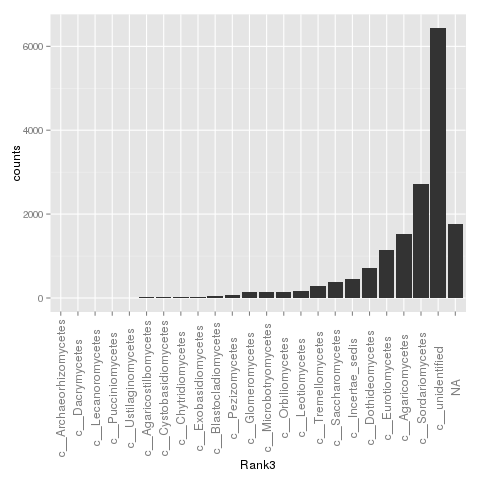

In [12]:
%%R
comp_all$Rank3 <- factor(comp_filt$Rank3, levels = comp_filt$Rank3[order(comp_filt$counts)])
p = ggplot(comp_filt, aes(x = Rank3, y = counts)) + geom_bar(stat = "identity")
p = p + theme(axis.text.x  = element_text(angle=90, vjust=0.5, size=12))
p

#### Get heavy fractions from physeq object

In [13]:
%%R
dna.density.min = 1.7125
#rna.density.min = 1.825

md = sample_data(physeq)
criterion = md$Density >= with(md, dna.density.min)

physeq.heavy = prune_samples(criterion, physeq)

####Function for estimating fold change and standard error with DESeq2

In [14]:
%%R
get_l2fc = function(physeq.obj, Day) {
    physeq.md = sample_data(physeq.obj)
    p = prune_samples(#physeq.md$RNA_DNA == RNA_DNA)&
                      (physeq.md$Day == Day), physeq.obj)
    dds = phyloseq_to_deseq2(p, ~Treatment)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE")])
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)
    d
}

####Function arguments

In [15]:
%%R
m = expand.grid(Day = c(3, 7, 14, 30))
m

  Day
1   3
2   7
3  14
4  30


####mdply call with function arguments

In [16]:
%%R
registerDoParallel(8)

df.l2fc = tbl_df(mdply(m, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq.heavy))
df.l2fc

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Joining by: "OTU"

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning:

Source: local data frame [8,128 x 11]

     Day     OTU log2FoldChange     lfcSE    Rank1           Rank2
   (dbl)   (chr)          (dbl)     (dbl)   (fctr)          (fctr)
1      3  OTU.40     -1.7995959 0.3482440 k__Fungi   p__Ascomycota
2      3   OTU.7      2.7460387 0.4049920 k__Fungi   p__Ascomycota
3      3   OTU.5     -0.3195079 0.5060621 k__Fungi   p__Ascomycota
4      3   OTU.3     -0.3862363 0.3147093 k__Fungi   p__Ascomycota
5      3  OTU.16      0.4177197 0.2757979 k__Fungi   p__Ascomycota
6      3  OTU.11     -1.5514248 0.3555538 k__Fungi   p__Ascomycota
7      3  OTU.33      0.1792172 0.5108838 k__Fungi p__unidentified
8      3   OTU.4      1.4770349 0.5564977 k__Fungi p__unidentified
9      3   OTU.1      2.1137485 0.4453256 k__Fungi              NA
10     3 OTU.466     -2.4615766 0.9747627 k__Fungi   p__Ascomycota
..   ...     ...            ...       ...      ...             ...
Variables not shown: Rank3 (fctr), Rank4 (fctr), Rank5 (fctr), Rank6 (fctr),
  Rank7 (fctr

#### Finding l2fc threshold as defined by 1 sd away from the mean l2fc for RNA/DNA combined

In [17]:
%%R
summarise(ungroup(df.l2fc),
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

   meanl2fc
      (dbl)
1 0.1862669


In [18]:
%%R
summarise(ungroup(df.l2fc),
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

    sdl2fc
     (dbl)
1 2.141092


#### log2fold change threshold set at 2.3

####Now get sparsity info for each OTU

In [19]:
%%R
mdf.heavy = tbl_df(psmelt(physeq.heavy))

In [20]:
%%R
sparsity.df = mdf.heavy %>%
    group_by(OTU, Day, RNA_DNA) %>%
    summarize(sparsity = sum(Abundance > 0) / length(Abundance)) %>%
    #filter(Treatment == "13CCPS") %>%
    select(OTU, Day, RNA_DNA, sparsity)

sparsity.df

Source: local data frame [8,128 x 4]
Groups: OTU, Day [8128]

         OTU   Day RNA_DNA   sparsity
       (chr) (int)  (fctr)      (dbl)
1      OTU.1     3     DNA 1.00000000
2      OTU.1     7     DNA 1.00000000
3      OTU.1    14     DNA 1.00000000
4      OTU.1    30     DNA 1.00000000
5     OTU.10     3     DNA 1.00000000
6     OTU.10     7     DNA 1.00000000
7     OTU.10    14     DNA 1.00000000
8     OTU.10    30     DNA 1.00000000
9  OTU.10011     3     DNA 0.05263158
10 OTU.10011     7     DNA 0.00000000
..       ...   ...     ...        ...


####Add sparsity information to l2fc table

In [21]:
%%R
df.l2fc = left_join(df.l2fc, sparsity.df)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Joining by: c("Day", "OTU")

  res = super(Function, self).__call__(*new_args, **new_kwargs)


####Add p-values to l2fc table

In [22]:
%%R
l2fc.threshold = 2.3
df.l2fc$p = with(df.l2fc, pnorm(log2FoldChange, l2fc.threshold, lfcSE, lower.tail = FALSE))

####Plot sparsity threshold versus number of adjusted p-values less than FDR

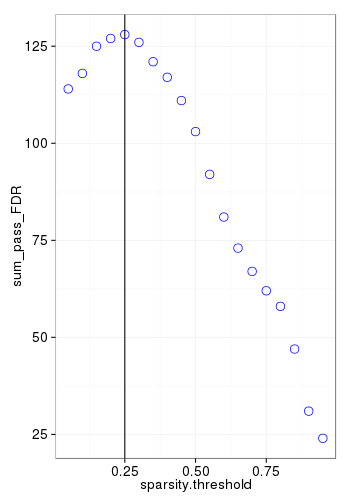

In [23]:
%%R -w 350 -h 500
FDR = 0.10

count_sig = function(df, sparsity.threshold) {
    d = df %>%
            filter(sparsity >= sparsity.threshold) %>%
            mutate(padj = p.adjust(p, method = "BH"))%>% 
            summarize(sum_pass_FDR = sum(padj <= FDR))
    d
}

thresh = seq(0.05, 0.95, 0.05)
names(thresh) = thresh

d.sparsity = ldply(thresh, count_sig, .id = "sparsity.threshold", df = df.l2fc)
d.sparsity$sparsity.threshold = as.numeric(as.character(d.sparsity$sparsity.threshold))

p = ggplot(d.sparsity, aes(x = sparsity.threshold, y = sum_pass_FDR))

#p = p + facet_wrap(~RNA_DNA, ncol = 1, scales = "free_y")

p = p + geom_point(size = 4, shape = 21, color = "blue")

p = p + geom_vline(x = 0.25)

p = p + theme_bw()
    
p = p + theme(axis.text = element_text(size = 14),
              axis.title = element_text(size = 14),
              strip.text = element_text(size = 14),
              strip.background = element_blank())

p

####Remove OTU/Day/RNA_DNA rows below sparsity threshold and add adjusted p-value to l2fc table 

In [24]:
%%R
sparsity.threshold = 0.25
df.l2fc = df.l2fc %>% 
    filter(sparsity >= sparsity.threshold) %>%
    mutate(padj = p.adjust(p, method = "BH"))
df.l2fc

Source: local data frame [1,892 x 15]

     Day     OTU log2FoldChange     lfcSE    Rank1           Rank2
   (dbl)   (chr)          (dbl)     (dbl)   (fctr)          (fctr)
1      3  OTU.40     -1.7995959 0.3482440 k__Fungi   p__Ascomycota
2      3   OTU.7      2.7460387 0.4049920 k__Fungi   p__Ascomycota
3      3   OTU.5     -0.3195079 0.5060621 k__Fungi   p__Ascomycota
4      3   OTU.3     -0.3862363 0.3147093 k__Fungi   p__Ascomycota
5      3  OTU.16      0.4177197 0.2757979 k__Fungi   p__Ascomycota
6      3  OTU.11     -1.5514248 0.3555538 k__Fungi   p__Ascomycota
7      3  OTU.33      0.1792172 0.5108838 k__Fungi p__unidentified
8      3   OTU.4      1.4770349 0.5564977 k__Fungi p__unidentified
9      3   OTU.1      2.1137485 0.4453256 k__Fungi              NA
10     3 OTU.466     -2.4615766 0.9747627 k__Fungi   p__Ascomycota
..   ...     ...            ...       ...      ...             ...
Variables not shown: Rank3 (fctr), Rank4 (fctr), Rank5 (fctr), Rank6 (fctr),
  Rank7 (fctr

In [25]:
%%R
df.l2fc$Rank2 = gsub("p__", "", df.l2fc$Rank2)
df.l2fc$Rank3 = gsub("c__", "", df.l2fc$Rank3)
df.l2fc$Rank4 = gsub("o__", "", df.l2fc$Rank4)
df.l2fc$Rank5 = gsub("f__", "", df.l2fc$Rank5)
df.l2fc$Rank6 = gsub("g__", "", df.l2fc$Rank6)
df.l2fc$Rank7 = gsub("s__", "", df.l2fc$Rank7)

In [26]:
%%R
head(df.l2fc$Rank)

NULL


In [27]:
%%R
write.table(df.l2fc, "data/l2fc_UNITE.csv", row.names = FALSE, sep = ",")
df.l2fc

Source: local data frame [1,892 x 15]

     Day     OTU log2FoldChange     lfcSE    Rank1        Rank2           Rank3
   (dbl)   (chr)          (dbl)     (dbl)   (fctr)        (chr)           (chr)
1      3  OTU.40     -1.7995959 0.3482440 k__Fungi   Ascomycota Sordariomycetes
2      3   OTU.7      2.7460387 0.4049920 k__Fungi   Ascomycota Sordariomycetes
3      3   OTU.5     -0.3195079 0.5060621 k__Fungi   Ascomycota Sordariomycetes
4      3   OTU.3     -0.3862363 0.3147093 k__Fungi   Ascomycota Sordariomycetes
5      3  OTU.16      0.4177197 0.2757979 k__Fungi   Ascomycota              NA
6      3  OTU.11     -1.5514248 0.3555538 k__Fungi   Ascomycota Sordariomycetes
7      3  OTU.33      0.1792172 0.5108838 k__Fungi unidentified    unidentified
8      3   OTU.4      1.4770349 0.5564977 k__Fungi unidentified    unidentified
9      3   OTU.1      2.1137485 0.4453256 k__Fungi           NA              NA
10     3 OTU.466     -2.4615766 0.9747627 k__Fungi   Ascomycota Sordariomycetes
.

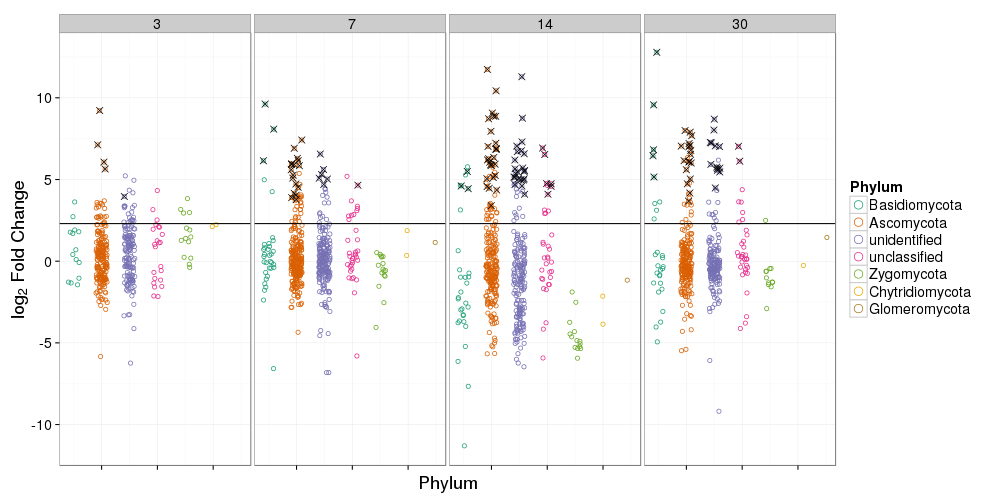

In [28]:
%%R -w 1000 -h 500
d = df.l2fc
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))
p = p + facet_wrap(~Day, nrow=1, ncol=4)

p = p + geom_point(alpha = 1.00, shape = 21, size = 2)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj <= FDR), color = "black", shape = 4, size = 3)

p = p + geom_hline(y = l2fc.threshold)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p = p + theme(text = element_text(size=18)) 

p

In [29]:
%%R
ggsave(filename = "data/figs/l2fc_byphyla.pdf", plot = p, width = 12, height = 7)

In [93]:
%%R
sord = filter(df.l2fc, padj <=0.10) 
length((sord$OTU))

[1] 128


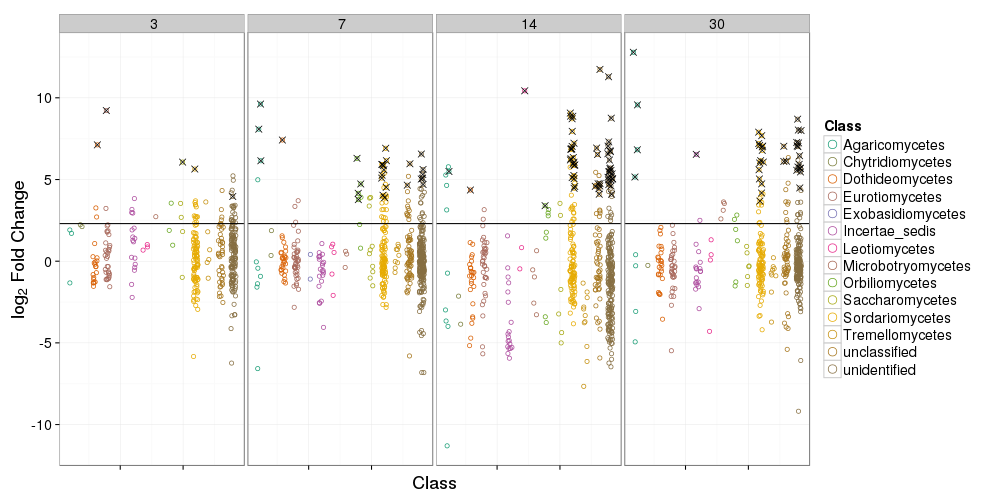

In [30]:
%%R -w 1000 -h 500
d = df.l2fc
FDR = 0.10

d$Rank3 = as.character(d$Rank3)
d$Rank3[is.na(d$Rank3)] = "unclassified"
d$Rank3 = factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank3)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank3))
p = p + facet_wrap(~Day, nrow=1, ncol=4)

p = p + geom_point(alpha = 1.00, shape = 21, size = 2)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj <= FDR), color = "black", shape = 4, size = 3)

p = p + geom_hline(y = l2fc.threshold)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Class", color = "Class")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p = p + theme(text = element_text(size=18)) 

p

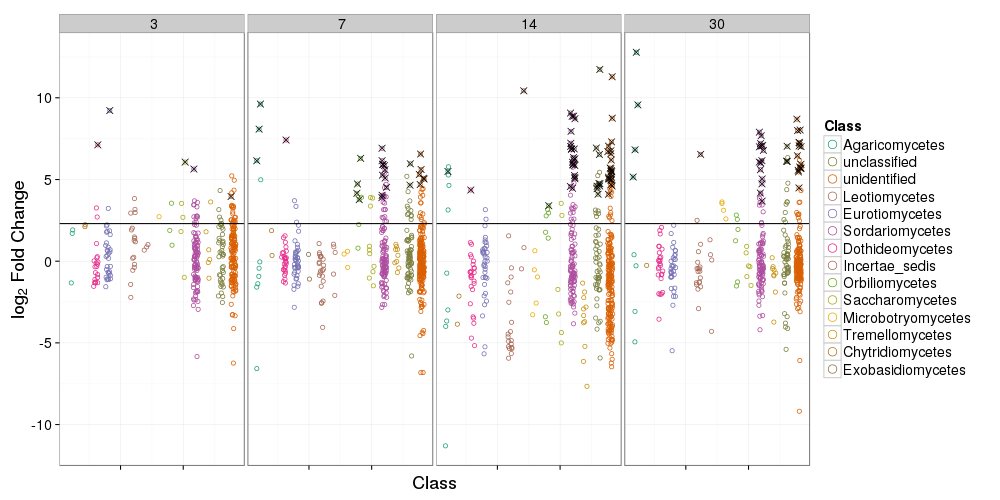

In [31]:
%%R -w 1000 -h 500
d = df.l2fc
FDR = 0.10

d$Rank3 = as.character(d$Rank3)
d$Rank3[is.na(d$Rank3)] = "unclassified"
d$Rank3 = factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank4 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank3)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank4))
p = p + facet_wrap(~Day, nrow=1, ncol=4)

p = p + geom_point(alpha = 1.00, shape = 21, size = 2)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj <= FDR), color = "black", shape = 4, size = 3)

p = p + geom_hline(y = l2fc.threshold)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Class", color = "Class")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p = p + theme(text = element_text(size=18)) 

p

In [32]:
%%R
ggsave(filename = "data/figs/l2fc_byclass.pdf", plot = p, width = 12, height = 7)

In [96]:
%%R 
f = filter(df.l2fc, padj <=0.10)
f2 = f %>%
group_by(Rank3, Day) %>%
summarise(counts = n())

In [97]:
%%R
f2[is.na(f2)] = "unclassified"

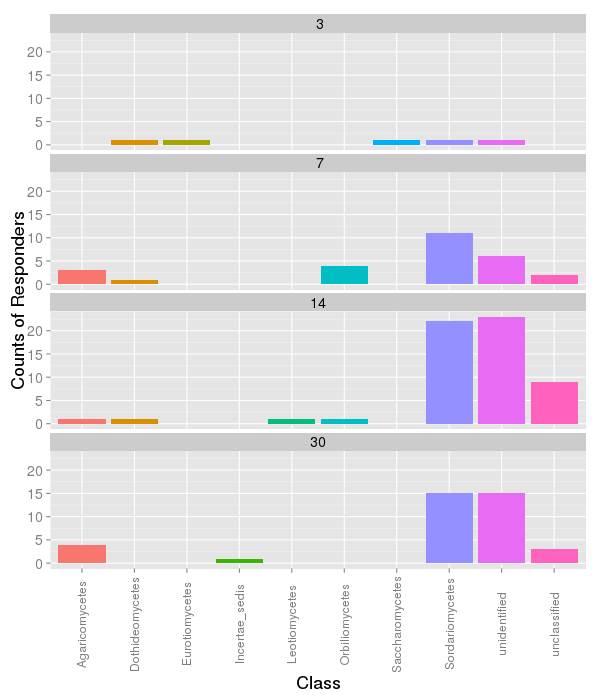

In [98]:
%%R -w 600 -h 700
f2$Rank3 <- factor(f2$Rank3, levels = f2$Rank3[order(f2$counts)])
p = ggplot(f2, aes(x = Rank3, y = counts, fill = Rank3)) + geom_bar(stat = "identity")
p = p + theme(axis.text.x  = element_text(angle=90, vjust=0.5, size=12))
p = p + guides(fill = FALSE)
p = p + facet_wrap(~Day, ncol = 1)
p = p + theme(text = element_text(size=18))
p = p + ylab("Counts of Responders") + xlab("Class")
p

In [99]:
%%R
filter(f2, is.na(Rank3))
filter(f2, Rank3 == "unidentified")
summarise(f2,
  sumcounts = sum(counts, na.rm = TRUE))# %>%
#summarise(sumsum = sum(sumcounts))

Source: local data frame [10 x 2]

             Rank3 sumcounts
            (fctr)     (int)
1   Agaricomycetes         8
2  Dothideomycetes         3
3   Eurotiomycetes         1
4   Incertae_sedis         1
5    Leotiomycetes         1
6   Orbiliomycetes         5
7  Saccharomycetes         1
8  Sordariomycetes        49
9     unidentified        45
10    unclassified        14


In [127]:
%%R
hypo = filter(df.l2fc, Rank4 == "Hypocreales", padj <=0.10)

[1] "Clavicipitaceae" "Incertae_sedis"  "Clavicipitaceae"


In [128]:
%%R
hypo2 = filter(df.l2fc, OTU %in% hypo$OTU)

In [37]:
%%R
ggsave(filename = "data/figs/respbyClass.pdf", plot = p, width = 6, height = 7)

In [120]:
%%R 
f = filter(df.l2fc, padj <=0.10)
f2 = f %>%
group_by(Rank4) %>%
summarise(counts = n())

In [121]:
%%R
f2

Source: local data frame [13 x 2]

               Rank4 counts
               (chr)  (int)
1         Agaricales      1
2          Boletales      1
3     Cantharellales      3
4         Eurotiales      1
5        Hypocreales      3
6     Incertae_sedis      4
7         Orbiliales      5
8       Pleosporales      2
9  Saccharomycetales      1
10       Sebacinales      3
11       Sordariales     45
12      unidentified     45
13                NA     14


In [100]:
%%R 
f = filter(df.l2fc, padj <=0.10)
f2 = f %>%
group_by(Rank5, Day) %>%
summarise(counts = n())

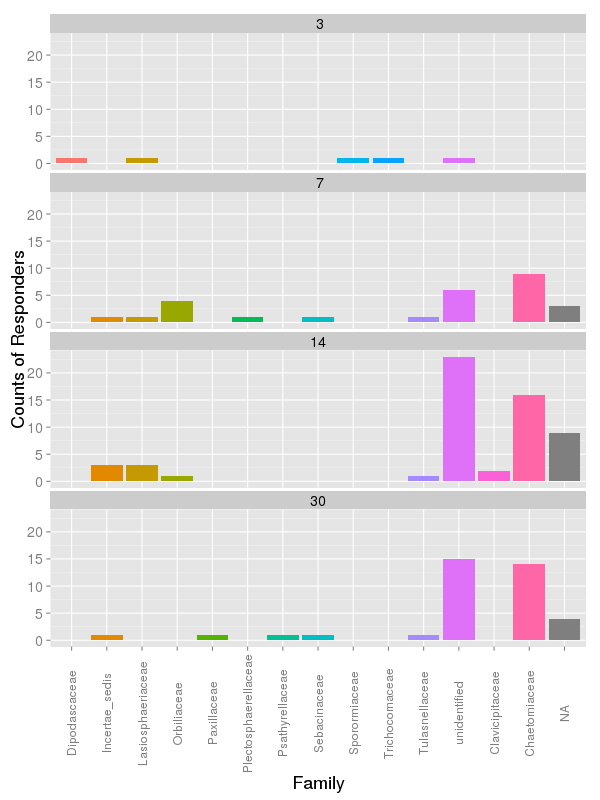

In [101]:
%%R -w 600 -h 800
f2$Rank5 <- factor(f2$Rank5, levels = f2$Rank5[order(f2$counts)])
p = ggplot(f2, aes(x = Rank5, y = counts, fill = Rank5)) + geom_bar(stat = "identity")
p = p + theme(axis.text.x  = element_text(angle=90, vjust=0.5, size=12))
p = p + guides(fill = FALSE)
p = p + facet_wrap(~Day, ncol = 1)
p = p + theme(text = element_text(size=18))
p = p + ylab("Counts of Responders") + xlab("Family")
p

In [108]:
%%R
(f2) %>% group_by(Rank5) %>% summarise(s = sum(counts)) 

Source: local data frame [15 x 2]

                  Rank5     s
                 (fctr) (int)
1         Dipodascaceae     1
2        Incertae_sedis     5
3     Lasiosphaeriaceae     5
4           Orbiliaceae     5
5           Paxillaceae     1
6  Plectosphaerellaceae     1
7       Psathyrellaceae     1
8          Sebacinaceae     2
9         Sporormiaceae     1
10       Trichocomaceae     1
11       Tulasnellaceae     3
12         unidentified    45
13      Clavicipitaceae     2
14        Chaetomiaceae    39
15                   NA    16


In [40]:
%%R 
f = filter(df.l2fc, padj <=0.10)
f2 = f %>%
group_by(Rank6, Day) %>%
summarise(counts = n())

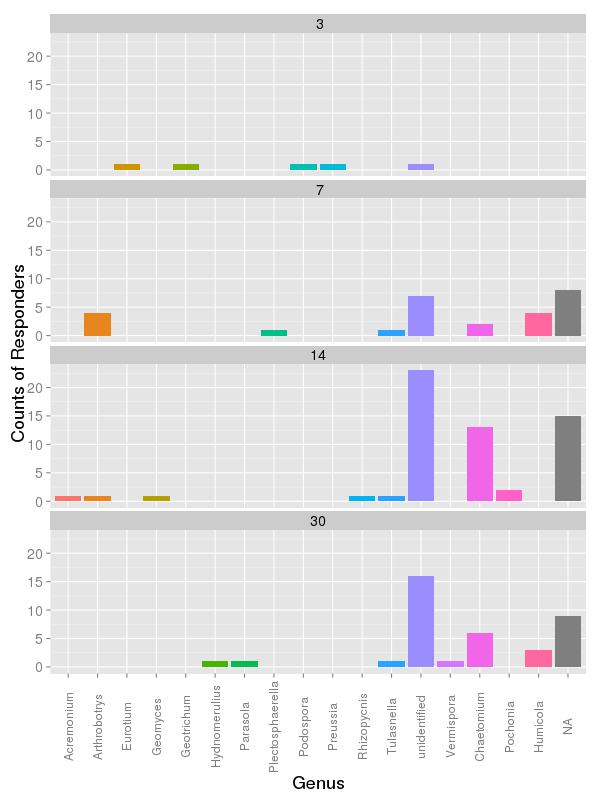

In [41]:
%%R -w 600 -h 800
f2$Rank6 <- factor(f2$Rank6, levels = f2$Rank6[order(f2$counts)])
p = ggplot(f2, aes(x = Rank6, y = counts, fill = Rank6)) + geom_bar(stat = "identity")
p = p + theme(axis.text.x  = element_text(angle=90, vjust=0.5, size=12))
p = p + guides(fill = FALSE)
p = p + facet_wrap(~Day, ncol = 1)
p = p + theme(text = element_text(size=18))
p = p + ylab("Counts of Responders") + xlab("Genus")
p

In [42]:
%%R
ggsave(filename = "data/figs/respbyGenus.pdf", plot = p, width = 6, height = 7)

In [43]:
%%R 
f = filter(df.l2fc, padj <=0.10)
f2 = f %>%
group_by(Rank7, Day) %>%
summarise(counts = n())

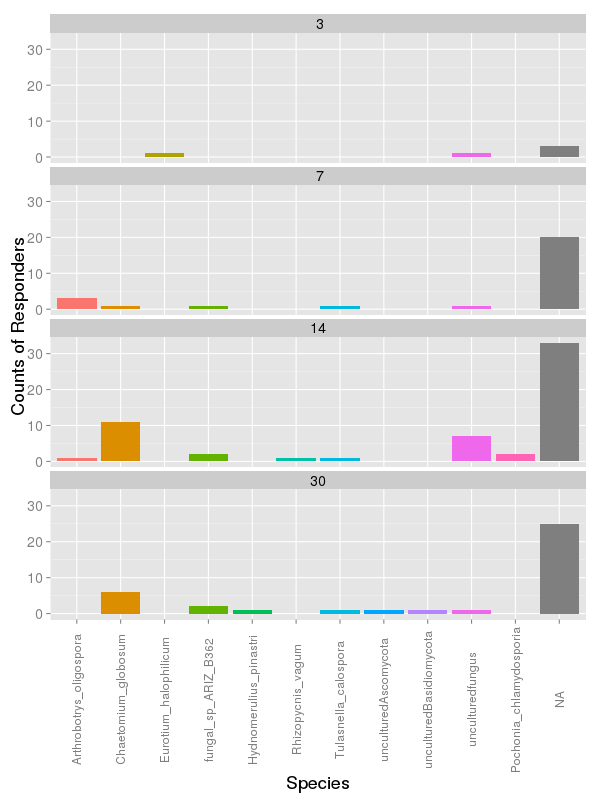

In [44]:
%%R -w 600 -h 800
f2$Rank7 <- factor(f2$Rank7, levels = f2$Rank7[order(f2$counts)])
p = ggplot(f2, aes(x = Rank7, y = counts, fill = Rank7)) + geom_bar(stat = "identity")
p = p + theme(axis.text.x  = element_text(angle=90, vjust=0.5, size=12))
p = p + guides(fill = FALSE)
p = p + facet_wrap(~Day, ncol = 1)
p = p + theme(text = element_text(size=18))
p = p + ylab("Counts of Responders") + xlab("Species")
p

In [45]:
%%R
ggsave(filename = "data/figs/respbyGenus.pdf", plot = p, width = 6, height = 7)

In [46]:
%%R
ggsave(filename = "data/figs/responders_hist_byClass.pdf", plot = p, width = 6, height = 7)

In [47]:
%%R

#OTUS that are responders by day
Day3 = filter(df.l2fc, Day == 3, padj <=0.10)
Day7 = filter(df.l2fc, Day == 7, padj <=0.10)
Day14 = filter(df.l2fc, Day == 14, padj <=0.10)
Day30 = filter(df.l2fc, Day == 30, padj <=0.10)

print(length(Day3$OTU))
print(length(Day7$OTU))
print(length(Day14$OTU))
print(length(Day30$OTU))


[1] 5
[1] 27
[1] 58
[1] 38


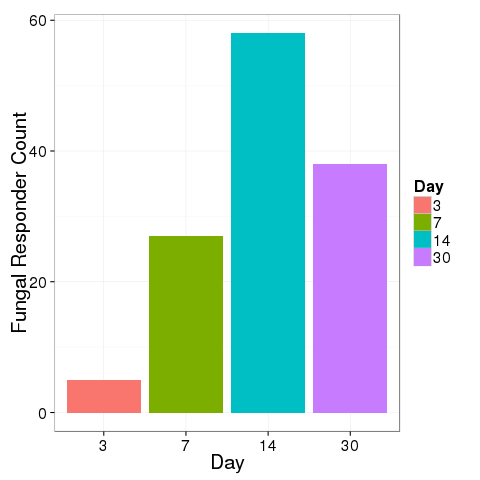

In [48]:
%%R
d = df.l2fc %>%
          group_by(Day) %>%
          summarize(responders = sum(padj <= 0.10))

px = ggplot(d, aes(x = factor(Day), y = responders, fill = factor(Day)))

px = px + geom_bar(stat = "identity", position = "dodge")

px = px + theme_bw()

px = px + xlab("Day") + ylab("Fungal Responder Count")

px = px + scale_fill_discrete(name = "Day")

px = px + theme(text = element_text(size=20))


px

In [49]:
%%R
ggsave(filename = "data/figs/l2fc_histogram_fungi.pdf", plot = px, width = 6, height = 6)

In [50]:
%%R
l2fc.df = tbl_df(read.table("/home/ashley/succ-C-DNASIP/data/l2fc_table.csv",
           sep = ",",
           header = TRUE))
l2fc.df = filter(l2fc.df, Treatment == "13CCPS")

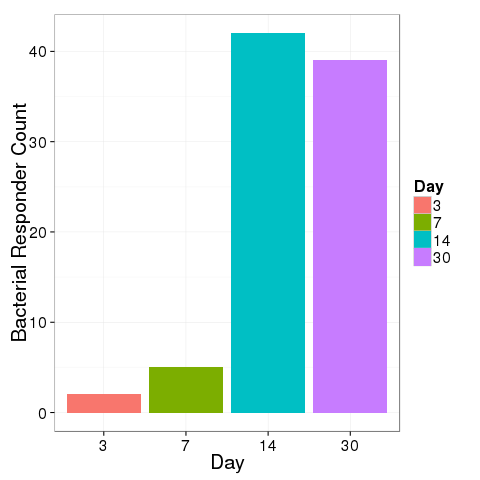

In [51]:
%%R
d = l2fc.df %>%
          group_by(Day) %>%
          summarize(responders = sum(padj <= 0.10))

px = ggplot(d, aes(x = factor(Day), y = responders, fill = factor(Day)))

px = px + geom_bar(stat = "identity", position = "dodge")

px = px + theme_bw()

px = px + xlab("Day") + ylab("Bacterial Responder Count")

px = px + scale_fill_discrete(name = "Day")

px = px + theme(text = element_text(size=20))


px

In [52]:
%%R
ggsave(filename = "data/figs/l2fc_histogram_bacteria.pdf", plot = px, width = 6, height = 6)

In [53]:
%%R
library(tidyr); library(magrittr)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘tidyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:IRanges’:

    expand


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘magrittr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:tidyr’:

    extract


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [54]:
%%R
data = data.frame(Day = c(0, 3, 7, 14, 30),
                  cellulose = c(100, 88.7, 78.8, 62.4, 39.8)) %>%
    gather(Substrate, "Percent left", -Day) %>%
    na.omit
    
data

  Day Substrate Percent left
1   0 cellulose        100.0
2   3 cellulose         88.7
3   7 cellulose         78.8
4  14 cellulose         62.4
5  30 cellulose         39.8


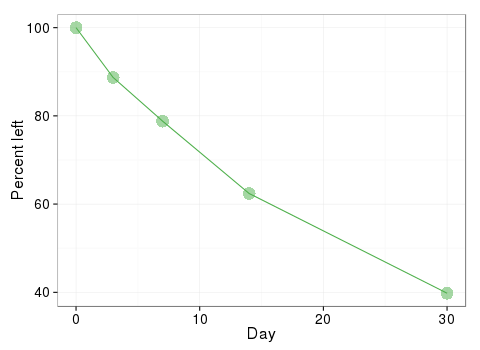

In [55]:
%%R -h 350
p = ggplot(data, aes(x = Day, y = `Percent left`, color = Substrate))

p = p + geom_point(size = 6, alpha = 0.5)
p = p + geom_line()
p = p + labs(x = "Day")
p = p + scale_color_manual(values = c("#4daf4a", "#377eb8"))
p = p + theme_bw()
p = p + theme(axis.text = element_text(size = 14),
              axis.title = element_text(size = 16), 
              legend.text = element_text(size = 14), 
              legend.title = element_text(size = 16))
p = p + guides(color = FALSE)

p

In [56]:
%%R
ggsave(filename = "data/figs/13C-CelluloseLeft.pdf", plot = p, width = 5, height = 4)

In [57]:
%%R
library(stats)

In [58]:
%%R
s <- seq(from = 1.60, to = 1.74, by = 0.0005)
a = rnorm(s,1.68, 0.05)
b = rnorm(s,1.70, 0.05)

In [59]:
%%R
val = "A"
a2 = data.frame(a, val)

In [60]:
%%R
val = "B"
b2 = data.frame(b, val)

In [61]:
%%R
colnames(b2)[colnames(b2)=="b"] <- "a"

In [62]:
%%R
ab = rbind(a2,b2)
#ab$seq = s

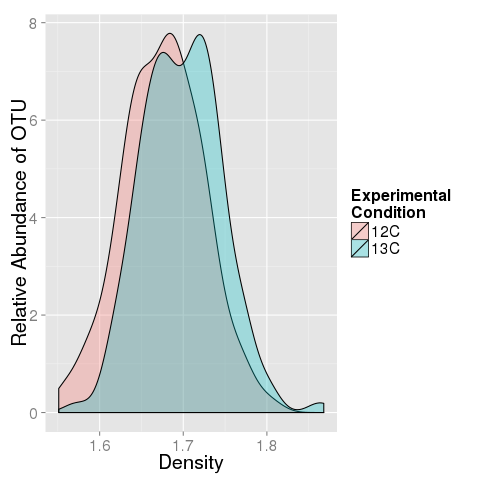

In [63]:
%%R
p = ggplot(ab, aes(x=a, fill=val)) + geom_density(alpha=.3) + ylab("Relative Abundance of OTU") + xlab("Density") +
 theme(text = element_text(size=20)) + scale_fill_discrete(name="Experimental\nCondition",
                         labels=c("12C", "13C"))

p



In [64]:
%%R
ggsave(filename = "data/figs/Densitydist_schematic.pdf", plot = p, width = 6, height = 4)

In [65]:
%%R
 new_df.l2fc = df.l2fc %>% 
filter(!is.na(log2FoldChange)) %>% 
filter(!is.na(padj)) %>%
select(log2FoldChange, padj, OTU, Rank7) 

In [66]:
%%R
new_df.l2fc$Resp_status[new_df.l2fc$padj > 0.10] = "non-responder/unknown"
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 & new_df.l2fc$log2FoldChange > 0] = "Responder"

In [67]:
%%R
responders = filter(new_df.l2fc, Resp_status == "Responder")

In [68]:
%%R
resp = filter(new_df.l2fc, OTU %in% responders$OTU)

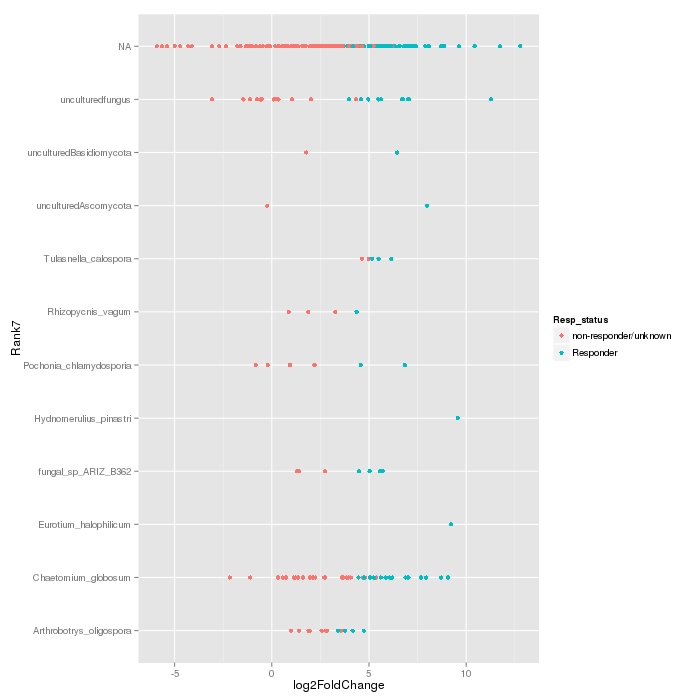

In [69]:
%%R -w 700 -h 700
p = ggplot(resp, aes(log2FoldChange, Rank7))
p = p + geom_point(aes(color = Resp_status))
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
#p = p + scale_colour_discrete((name="Responder Status"),
 #                        labels =c("Nonresponder/Unknown", "DNA and RNA Responder"))
p

In [70]:
%%R -w 700 -h 700
p = ggplot(new_df.l2fc, aes(log2FoldChange, Rank6))
p = p + geom_point(aes(color = Resp_status))
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
#p = p + scale_colour_discrete((name="Responder Status"),
 #                        labels =c("Nonresponder/Unknown", "DNA and RNA Responder"))
p

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : object 'Rank6' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: There were 24 warnings (use warnings() to see them)
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


RRuntimeError: Error in eval(expr, envir, enclos) : object 'Rank6' not found


## Blasting against Living Tree Project db

In [ ]:
from Bio.Blast.Applications import NcbiblastnCommandline as blast

In [ ]:
from cogent import LoadSeqs, DNA


In [ ]:
OTU_ids = ["OTU.162", "OTU.239", "OTU.2456", "OTU.256", "OTU.3194", "OTU.80"]
seqs = LoadSeqs("/home/chantal/RNASIP/data/totalRNA.otusn.fasta", moltype=DNA, aligned=False)
seqs = seqs.takeSeqs(OTU_ids).toFasta()
print seqs

In [ ]:
my_file = open("seqs.fasta", "w")
my_file.write(seqs)
my_file.close()

In [ ]:
cline = blast(query = "seqs.fasta",
              db = "/var/seq_data/silva/silva_blastdb/silva_RefNR_115",
              outfmt = 6,
              out = "otusn_silvaRefNR115.m6",
              num_threads = 5)
print cline
cline()

In [ ]:
!head -n1 otusn_silvaRefNR115.m6
!wc -l otusn_silvaRefNR115.m6
! grep -c "OTU.80" otusn_silvaRefNR115.m6

In [ ]:
from IPython.display import Image
import pandas.rpy.common as com

In [ ]:
%%R
library(data.table)
library(dplyr)

In [ ]:
%%R
blastout_dt = fread("otusn_silvaRefNR115.m6")
blastout_df = tbl_df(blastout_dt)
colnames(blastout_df) = c("OTU",
                        "acc",
                        "pid",
                        "aln.length",
                        "mismatches",
                        "gapOpenCount",
                        "qstart",
                        "qend",
                        "sstart",
                        "send",
                        "e.value",
                        "bit.score")

top_hits_df_LTP = blastout_df %>% 
                          group_by(OTU) %>% 
                          mutate(Rank = rank(desc(bit.score), ties.method = "min")) %>% 
                          filter(pid > 97.0) %>%
                          filter(e.value < 5.0e-180) %>%
                          filter(acc %in% c('AM286414', 'AB428568', 'EU877263', 'EF575565', 'EF494193', 'X82449'))

In [ ]:
%%R
print(head(top_hits_df_LTP))
str(top_hits_df_LTP$OTU)

In [ ]:
%%R
dt = fread("/var/seq_data/LTP115_db/LTPs115_SSU.csv", sep = ";")
colnames(dt) = c("acc","start","end","DB.version","name","unknown1","family","unknown2","url","full_tax")
LTP_seq_data = tbl_df(dt)

In [ ]:
%%R
joined_df = left_join(top_hits_df_LTP, LTP_seq_data)

In [ ]:
%%R
joined_df = filter(joined_df, name != "NA")

In [ ]:
%%R
dim(joined_df)

In [ ]:
df = com.load_data("joined_df")

In [ ]:
def get_latex(df):
    latex = ""
    prefix = r"\multirow{%s}{*}{%s}"%(len(df.index), df.OTU.iloc[0])
    for i, r in df[["name","pid","acc"]].iterrows():
        latex += " & " + " & ".join([str(i) for i in r.values]) + r" \\ "
    return prefix + latex + r"\midrule" + "\n"

In [ ]:
s = df.groupby("OTU").apply(get_latex)

table_framework = r"""
\documentclass[11pt]{article}
\usepackage{multirow, array, booktabs}
\begin{document}

\thispagestyle{empty}
 
\begin{table}[ht]
\caption{$^{13}$C RNA responders BLAST against Living Tree Project}
\begin{center}
\begin{tabular}{l>{\itshape}lrl}
    \toprule \\
    \textbf{OTU ID} & \textbf{Species Name} & \textbf{BLAST percent identity} & \textbf{accession} \\
    \midrule
    %s
    \bottomrule
\end{tabular}
\end{center}
\label{tab:multicol}
\end{table}
 
\end{document}"""%"".join(s.values)

with open("../data/tmp/table.tex", "w") as out:
    out.write(table_framework)

In [ ]:
!latex -output-directory="../data/tmp" ../data/tmp/table.tex >/dev/null 2>&1 && \
dvipng -o ../data/table.png ../data/tmp/table.dvi >/dev/null 2>&1
Image("../data/table.png")